<a href="https://colab.research.google.com/github/tsawsum/MLClass/blob/main/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial

Link to sample code

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Classes for loading the data from the Vesuvius challenge. Made to be compatible with tf.keras.utils.Sequence. Written by Brett Foster

Documentation in comments at the bottom of the code block

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# with np.load('/content/gdrive/My Drive/Pomona/Classes/Junior Year/Spring/Machine Learning/Final Project/Data/') as data

DATA_PATH = 'C:/Users/ttsaw/Desktop/vesuvius-challenge-ink-detection'

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm


IMAGE_SHAPES = {'1': (8181, 6330), '2': (14830, 9506), '3': (7606, 5249), 'a': (2727, 6330), 'b': (5454, 6330)}
IMAGE_MASK_COUNTS = {'1': (29142840, 5339362), '2': (97993501, 16865122), '3': (25065492, 3172466), 'a': (10818923, 0), 'b': (18323917, 0)}


class VesuviusSequence:  # (tf.keras.utils.Sequence):
    def __init__(self, *, images='', input_buffer=1, z_start=0, z_end=65,
                 cached_rows=None, batch_size=1, mask_suffix='', transforms=None):
        self.images = sorted(map(str, set(images)))
        self.buffer = input_buffer
        self.z_range = (z_start, z_end)
        self.cached_rows = cached_rows
        self.batch_size = 1000000000 if batch_size is None else batch_size
        self.mask_suffix = mask_suffix
        self.transforms = [0] if transforms is None else (list(range(8)) if transforms == 'all' else
                                                          ([transforms] if isinstance(transforms, int) else transforms))

        self.files = {image: self.get_files(image) for image in self.images}
        self.segment_counts = {image: self.get_segment_counts(image) for image in self.images}
        self.image_order = [(image, i) for image in self.images for i in range(len(self.segment_counts[image]))]   # order of each segment (x seg pos, y seg pos). Will eventually shuffle
        self.currently_loaded = None     # tuple of whatever is currently loaded
        self.arr = np.zeros((0,))
        self.order = np.zeros((0,))   # will later contain the pixel orders (x pixel pos, y pixel pos, transform val (0-7 in this case))

    def __len__(self):
      # how many total batches there are
        return sum(self.num_batches(c) for counts in self.segment_counts.values() for c in counts)

    def __getitem__(self, idx):
        return NotImplemented

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

    def num_batches(self, segment_count):
        # how many batches there are for a given segment (the pieces we broke the images into)
        return int(np.ceil(segment_count * len(self.transforms) / self.batch_size))

    def load(self, img_idx):
        # loads the image into memory
        # if already loaded, done
        if self.currently_loaded == img_idx:
            return None
        self.currently_loaded = img_idx
        rows = IMAGE_SHAPES[img_idx[0]][0] if self.cached_rows is None else self.cached_rows
        # Load xray
        # Creates largers array around segment (because accounts for surrounding buffer). If out of bounds says there is no papyrus or ink there
        self.arr = np.zeros((self.z_range[1]-self.z_range[0], 2*self.buffer+rows,
                             IMAGE_SHAPES[img_idx[0]][1]+2*self.buffer), dtype='float32')
        r1, r2 = img_idx[1]*rows-self.buffer, (img_idx[1]+1)*rows+self.buffer
        offset, r1, r2 = max(0, -r1), max(r1, 0), min(r2, IMAGE_SHAPES[img_idx[0]][0])
        e1, e2 = offset + r2 - r1, self.arr.shape[2] - self.buffer
        for i, file in enumerate(self.files[img_idx[0]][2]):
            self.arr[i, offset:e1, self.buffer:e2] = cv2.imread(file, cv2.IMREAD_ANYDEPTH)[r1:r2]
        self.arr /= 65535.0
        # Load mask
        # Loads mask, gets list of pixels and transforms (x pos, y pos, transform)
        r1, r2 = img_idx[1]*rows, min((img_idx[1]+1)*rows, IMAGE_SHAPES[img_idx[0]][0])
        mask = np.zeros(self.arr.shape[1:])
        b = self.buffer, self.buffer + r2 - r1, self.buffer, mask.shape[1] - self.buffer
        mask[b[0]:b[1], b[2]:b[3]] = cv2.imread(self.files[img_idx[0]][0], cv2.IMREAD_GRAYSCALE)[r1:r2]
        x, y = np.where(mask > 127)
        transform = np.tile(np.array(self.transforms), len(x)).reshape(1, -1)
        self.order = np.vstack((np.stack((x, y)).repeat(len(self.transforms), axis=1), transform)).T
        return b, r1, r2

    def index_to_order_index(self, idx):
        # index 0 gets first _batchsize_ number of thruples (x pos, y pos, transform).
        # this is what keras uses to iterate through, must convert to the segment number which we use in this class
        # converts the index value to the image segment reference, plus which pixel it refers to
        for img, i in self.image_order:
            n = self.num_batches(self.segment_counts[img][i])
            if idx < n:
                self.load((img, i))
                break
            idx -= n
        return idx * self.batch_size

    def get_image(self, order_idx):
        # transform makes extra data points
        # takes the thruple, loads the image portion, and rotates/flips, etc.
        i, j, transform = self.order[order_idx]
        arr = self.arr[:, i-self.buffer:i+self.buffer+1, j-self.buffer:j+self.buffer+1]
        if transform == 0:
            return arr
        elif transform < 4:
            return np.rot90(arr, transform, (1, 2))
        elif transform == 4:
            return arr.transpose((0, 2, 1))
        else:
            return np.rot90(arr.transpose((0, 2, 1)), transform - 4, (1, 2))

    def get_files(self, image):
        # gets filepaths for exrays, inklables, mask
        folder = f'{DATA_PATH}/test/{image}' if image in ('a', 'b') else f'{DATA_PATH}/train/{image}'
        mask = f'{folder}/mask{self.mask_suffix}.png'
        labels = f'{folder}/inklabels.png'
        layers = [f'{folder}/surface_volume/{str(i).zfill(2)}.tif' for i in range(*self.z_range)]
        return mask, labels, layers

    def get_segment_counts(self, image):
        # takes an image name and loads inklables.png, and spits out a dict like
        # {1: [1000, 5000, 4000,... n sections]}
        mask = cv2.imread(self.files[image][0], cv2.IMREAD_GRAYSCALE)
        rows = len(mask) if self.cached_rows is None else self.cached_rows
        return [(mask[i:i+rows] > 127).sum() for i in range(0, len(mask), rows)]


class VesuviusTrainingSequence(VesuviusSequence):
    # Inherets from the orginal class
    def __init__(self, images='123', transforms='all', seed=None, **kwargs):
        VesuviusSequence.__init__(self, images=images, transforms=transforms, **kwargs)
        self.seed = seed
        np.random.default_rng(seed).shuffle(self.image_order)
        self.rng_states = dict()
        self.labels = np.zeros((0,))

    def __getitem__(self, idx):
        # gets first and last index, and gets image of each of the thruples in that range. Puts it in the right format for keras. Also gets label. 
        # returns x_data, y_data for this batch
        order_idx = self.index_to_order_index(idx)
        max_order_idx = min(order_idx + self.batch_size, len(self.order))
        return (np.stack([self.get_image(i) for i in range(order_idx, max_order_idx)]),
                np.stack([self.get_label(i) for i in range(order_idx, max_order_idx)]))

    def get_label(self, order_idx):
        i, j, _ = self.order[order_idx]
        return self.labels[i, j, :]

    def load(self, img_idx):
        # calls orginal load function, also gets the ink lables/ loads that image to memoery as well
        res = VesuviusSequence.load(self, img_idx)
        if res is None:
            return None
        b, r1, r2 = res
        self.labels = np.zeros((*self.arr.shape[1:], 1))
        self.labels[b[0]:b[1], b[2]:b[3], 0] = cv2.imread(self.files[img_idx[0]][1], cv2.IMREAD_GRAYSCALE)[r1:r2]
        self.labels /= 255.0
        if self.seed is None:
            rng = np.random.default_rng()
            if img_idx not in self.rng_states:
                self.rng_states[img_idx] = rng.__getstate__()   # all this stuff makes it deterministic
            else:
                rng.__setstate__(self.rng_states[img_idx])
            rng.shuffle(self.order)
        else:
            seed = (self.seed + img_idx[1] + 10000000 * self.images.index(img_idx[0]))
            np.random.default_rng(seed).shuffle(self.order)
        return res


class VesuviusPredictionSequence(VesuviusSequence):
    # does not have lables, and does not randomize the order
    def __init__(self, images='ab', **kwargs):
        VesuviusSequence.__init__(self, images=images, mask_suffix='', **kwargs)

    def __getitem__(self, idx):
        # gets a batch of samples
        # only the x values this time
        order_idx = self.index_to_order_index(idx)
        max_order_idx = min(order_idx + self.batch_size, len(self.order))
        return np.stack([self.get_image(i) for i in range(order_idx, max_order_idx)]),

    def create_image(self, predictions, method='mean', cutoff=0.5):
        # median or mean, median is equivalent to voting
        # if it works, should look identicle to inklables.png
        predictions = np.concatenate(list(predictions)).reshape((-1, len(self.transforms)))
        if method == 'mean':
            predictions = predictions.mean(axis=1)
        elif method == 'median':
            predictions = np.median(predictions, axis=1)
        predictions = (predictions >= cutoff).astype('uint8') * 255
        output_files = list()
        for image in self.images:
            n = sum(self.segment_counts[image])
            mask = cv2.imread(self.files[image][0], cv2.IMREAD_GRAYSCALE)
            mask[mask > 127] = predictions[:n]
            output_files.append(self.files[image][0].rpartition('/')[0] + '/prediction.png')
            if os.path.exists(output_files[-1]):
                os.remove(output_files[-1])
            cv2.imwrite(output_files[-1], mask)
            predictions = predictions[n:]
        return output_files


def split_mask(images, split_percents, split_names, ink_perc=None, seed=None):
    # take a portion of the mask for testing and training. 
    # random number for every pixel, 0.0 to split percents assigned to first group. 
    split_percents, split_names = zip(*((p, name) for p, name in zip(split_percents, split_names) if name))
    cutoffs, labels = [np.array([0.0, *np.cumsum(split_percents)])], None
    if ink_perc is not None:
        mask_counts = [IMAGE_MASK_COUNTS[image] for image in set(images) if image not in ('a', 'b')]
        n_total, n_ink = sum(x[0] for x in mask_counts), sum(x[1] for x in mask_counts)
        cutoffs.append((ink_perc * n_total / n_ink) * cutoffs[0])
        cutoffs.append(((1 - ink_perc) * n_total / (n_total - n_ink)) * cutoffs[0])
    for i in range(len(cutoffs)):
        if cutoffs[i].sum() > 1.0:
            cutoffs[i] *= (1.0 / cutoffs[i].sum())
    for image in set(images):
        folder = f'{DATA_PATH}/{"test" if str(image) in ("a", "b") else "train"}/{image}'
        mask = cv2.imread(f'{folder}/mask.png', cv2.IMREAD_GRAYSCALE)
        rand = np.random.default_rng(seed).random(mask.shape)
        if ink_perc is not None:
            labels = cv2.imread(f'{folder}/inklabels.png', cv2.IMREAD_GRAYSCALE)
        for i, name in enumerate(split_names):
            if not name:
                continue
            if ink_perc is None or image in 'ab':
                new_mask = ((mask > 127) & (cutoffs[0][i] <= rand) & (rand <= cutoffs[0][i+1])).astype('uint8') * 255
            else:
                new_mask = (labels > 127) & (mask > 127) & (cutoffs[1][i] <= rand) & (rand <= cutoffs[1][i+1])
                new_mask |= (labels <= 127) & (mask > 127) & (cutoffs[2][i] <= rand) & (rand <= cutoffs[2][i+1])
                new_mask = new_mask.astype('uint8') * 255
            output_file = f'{folder}/mask{name}.png'
            if os.path.exists(output_file):
                os.remove(output_file)
            cv2.imwrite(output_file, new_mask)


# split_mask(...) randomly splits mask.png into multiple parts with the given proportion of data points
# Can be used to create a train/test set, i.e. split_mask('1', [0.8, 0.2], ['train', 'test']) will create two new masks,
# with masktrain.png having 80% of the data points and masktest.png having 20% of the data points. These masks can then
# be used with VesuviusTrainingSequence and VesuviusPredictionSequence to only output that portion of the data
# Arguments:
#   images          - Which images to use e.g. '123', 'ab', '1'
#   split_percents  - List of percentages (0.0 to 1.0) to split the data, e.g. [0.6, 0.3, 0.1]
#                     If they sum to less than one, the remaining data will be discarded
#   split_names     - List of suffixes to append to the filename, i.e. 'test' creates the file masktest.png
#                     Must be the same length as split_percents. Use '' or None in the list to discard that split
#   ink_perc        - The percentage (0.0 to 1.0) of data points that should contain ink.
#                     Defaults to None, which keeps the same proportion as the original images
#   seed            - Random seed to use to split the data, defaults to None

# Arguments for VesuviusTrainingSequence and VesuviusPredictionSequence:
#   images          - Which images to use for data, e.g. '123', 'ab', '1'.
#                     Defaults to '123' for VesuviusTrainingSequence and 'ab' for VesuviusPredictionSequence
#   input_buffer    - Size of the area used to predict the output, e.g. 0 would be a 1x1 area, 1 would be a 3x3 area,
#                     5 would be a 11x11 area, etc. centered on the pixel that's being predicted. Defaults to 1
#   z_start         - Index of the first layer to use (inclusive), can be anything from 0 to 64. Defaults to 0
#   z_end           - Index of the last layer to use (exclusive), can be anything from z_start+1 to 65. Defaults to 65
#                     Using more layers significantly increases loading time and memory usage
#   cached_rows     - How many rows of the xray to store at once. Use None to store the entire xray. Defaults to None
#                     When using a lot of z layers, it can be basically impossible to store everything, so this
#                     significantly decreases memory usage while increasing loading time
#   batch_size      - Upper limit on the number of data points to output at a time. None = no limit. Defaults to 1
#                     Tries to output maximum possible, but will never output data from different caches in one batch
#   mask_suffix     - Which mask to use (mask{mask_suffix}.png), defaults to '' which is the original mask
#                     Meant to be used with split_mask(...) to create train/test data,
#                     where each name in split_names can be used as a mask_suffix here
#   transforms      - Includes transformations (flips/rotations) of the data to increase the number of trianing samples.
#                     0/None = no transformation, 1-3 = rotations, 4-7 = flip + rotations, 'all' = all of the above
#                     Pass a list to specify multiple transformations, e.g. [0, 1, 4].
#                     Defaults to 'all' for VesuviusTrainingSequence and None for VesuviusPredictionSequence
#   seed            - Random seed to shuffle the data, VesuviusTrainingSequence only. Defaults to None

# seq = VesuviusTrainingSequence(...)
# seq[i] outputs a tuple (X_data, y_data),
# where X_data is a numpy array with shape (batch_size, z_end-z_start, 2*buffer+1, 2*buffer+1), and each value in X_data is between 0.0 and 1.0
# and y_data is a numpy array with shape (batch_size, 1), with each value in y_data being either 0.0 for no ink or 1.0 for ink
# Can also iterate over all tuples with "for X_data, y_data in seq:"

# seq = VesuviusPredictionSequence(...)
# seq[i] outputs a tuple (X_data, ) where X_data is the same as in VesuviusTrainingSequence.
# Mainly for test images a and b, which don't have labels
# Will always output in the same order as the original image, unlike VesuviusTrainingSequence which is shuffled
# Also has the function seq.create_image(...) which creates prediction.png for each image showing where the ink
# is predicted to be, and returns a list of the output png files
# VesuviusPredictionSequence.create_image arguments:
#   predictions     - A list/tuple of the prediction batches, e.g. [your_model.predict(batch) for batch, in seq]
#   method          - 'mean' or 'median', defaults to 'mean'. Only matters if using more than one transformation, where
#                     it congregates the guesses from each transformation into a single prediction
#   cutoff          - The cutoff prediction value (after applying method) for whether or not a pixel has ink. Defaults to 0.5


The following code splits the data into test and training data using the split mask function. 
We used 1000000 samples because a larger amount takes a very long time to do gradient boosting with. 
We also used layer 10 to layer 25 only to save space; we do not use the top layers because the 
paper if of different thickness so some of the upper layers are 'air'.

In [ ]:
# Parameters
images = '123'
total_samples, train_split, test_split = 100000, 0.8, 0.2  # Approximately 5000 samples, 80% of which are training and 20% are testing
buffer, z_start, z_end = 3, 10, 25  # 2*buffer+1 = 7, z_end-z_start = 5 -> input shape is 7x7x5
# ONLY CAN FIT A CERTAIN AMOUNT IN RAM. 0 -15
cached_rows, batch_size = 4000, 256  # Increasing cached_rows and/or batch_size increases memory usage and decreases load time, but should have no effect on the data itself

def load_xy_data(mask):
    seq = VesuviusTrainingSequence(images=images, input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=cached_rows, batch_size=batch_size, mask_suffix=mask, transforms=None, seed=42)
    batches = [batch for batch in tqdm(seq, total=len(seq), desc=f'Loading {mask} data')]
    X_data, y_data = np.concatenate([x for x, y in batches]), np.concatenate([y for x, y in batches])
    return X_data.reshape(len(X_data), -1), y_data.flatten()

# Split into train/test
percent_data_used = total_samples / sum(IMAGE_MASK_COUNTS[image][0] for image in images)
split_mask(images, [train_split*percent_data_used, test_split*percent_data_used], ['train', 'test'], ink_perc=0.4, seed=42)   # ink_perc = 0.4 to force 40% to have ink because we only use 100k data points. 
# uses different cutoffs for ink pixels and non-ink pixels. Don't try this when using too many data points/ too high ink perc

# Load data
X_train, y_train = load_xy_data('train')
X_test, y_test = load_xy_data('test')

print('\nTrain data shape:', X_train.shape, y_train.shape)
print('\nTest data shape:', X_test.shape, y_test.shape)

Loading test data: 100%|██████████| 83/83 [00:54<00:00,  1.53it/s]


Train data shape: (80045, 735) (80045,)

Test data shape: (20077, 735) (20077,)


In [ ]:
# Function to predict the ink for a whole image
def show_prediction(image, model, prediction_cached_rows=500, prediction_batch_size=32):
    seq = VesuviusPredictionSequence(images=str(image), input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=prediction_cached_rows, batch_size=prediction_batch_size)
    predictions = [model.predict(X_data.reshape(len(X_data), -1)) for X_data, in tqdm(seq, total=len(seq), desc=f'Predicting image {image}')]
    output_file = seq.create_image(predictions)[0]
    im = cv2.imread(output_file, cv2.IMREAD_GRAYSCALE)
    plt.imshow(im, cmap='gray')

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

This is a unique classifier that takes advantage of the fact that we cannot load in all the data at once.
Data is split into sample batches of 256, and a third of the bathches are assigned to each classifier type.
This implimentation is helpful in the sense that it would allow us to theortically use more than 
the 100k data points more easily than the conventional classfiers.

In [ ]:
from itertools import pairwise

class BatchVotingClassifier:
    def __init__(self, classifiers):
        # takes in a list of classifiers
        self.estimators_ = self.clfs = classifiers
    
    def fit(self, seq):
        # takes in the training sequence class instead of normal xdata and ydata
        # checks how many batches are there, duvides batches equally among each classifier
        assert isinstance(seq, VesuviusTrainingSequence)
        seq_len = len(seq)
        assert seq_len >= len(self.clfs), 'Needs at least as many batches as estimators'
        batch_indices = [round(seq_len * i / len(self.clfs)) for i in range(len(self.clfs)+1)]
        for clf, (start_batch, stop_batch) in tqdm(zip(self.clfs, pairwise(batch_indices)), desc='Fitting batches', total=len(self.clfs)):
            X_data, y_data = zip(*(seq[i] for i in range(start_batch, stop_batch)))
            X_data, y_data = np.concatenate(X_data), np.concatenate(y_data)
            X_data, y_data = X_data.reshape(len(X_data), -1), y_data.flatten()
            clf.fit(X_data, y_data)
    
    def _predict_helper(self, X_batch, pb=None):
        # given x data, gets output for all classifiers, combines them by voting
        outputs = list()
        for clf in self.clfs:
            outputs.append(clf.predict(X_batch))
            if pb is not None:  # progress bar
                pb.update()
        outputs = (np.array(outputs) > 0.5).sum(axis=0)   # sum greater than half the number of classifiers
        return (outputs > (len(self.clfs) / 2)).astype('uint8').reshape((-1, 1))

    def predict(self, X):
        # takes either a sequence or a numpy array x test data
        if isinstance(X, VesuviusSequence):
            y = [self._predict_helper(batch[0]) for batch in tqdm(X, desc='Predicting')]
            return np.concatenate(y)
        with tqdm(total=len(self.clfs), desc='Predicting') as pb:
            return self._predict_helper(X, pb=pb)
    
    def score(self, X, y=None):
        # takes either sequence or array. counts how many predictions got correct/total preds = accuracy
        if isinstance(X, VesuviusTrainingSequence):
            num_samples, total_correct = 0, 0
            for X_data, y_data in tqdm(X, desc='Scoring'):
                num_samples += len(y_data)
                total_correct += (y_data == self._predict_helper(X_data)).sum()
            return total_correct / num_samples
        assert y is not None, 'Either pass one sequence or two numpy arrays'
        with tqdm(total=len(self.clfs), desc='Scoring') as pb:
            total_correct = (y == self._predict_helper(X, pb=pb)).sum()
        return total_correct / len(y)


AlwaysOne gives us a baseline understanding of what percentage of the trianing data is ink vs non ink.
In the whole papyrus, the ratio is abouu 80% non ink, but for training purposes we have forced the 
system to choose 60% non ink so it has more exposure to both types.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class AlwaysOneClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return [1] * len(X)

    def predict_proba(self, X):
        proba = [[0.0, 1.0]] * len(X)
        return proba

Training these trees takes FOREVER with large data set, so I had to limit the size of the data points. Also I was worried about running out of ram on collab, but the gradient boosting trees are actually the rate limiting step.

Training the GradientBoostingClassifier(n_estimators=50, random_state=42)
Training the GradientBoostingClassifier(random_state=42)
Training the GradientBoostingClassifier(n_estimators=150, random_state=42)
Training the GradientBoostingClassifier(learning_rate=0.001, n_estimators=150,
                           random_state=42)
Training the GradientBoostingClassifier(learning_rate=0.002326918171357704, n_estimators=150,
                           random_state=42)
Training the GradientBoostingClassifier(learning_rate=0.0054145481761946794,
                           n_estimators=150, random_state=42)
Training the GradientBoostingClassifier(learning_rate=0.012599210540879128, n_estimators=150,
                           random_state=42)
Training the GradientBoostingClassifier(learning_rate=0.029317331952333162, n_estimators=150,
                           random_state=42)
Training the GradientBoostingClassifier(learning_rate=0.06821903245560987, n_estimators=150,
                         

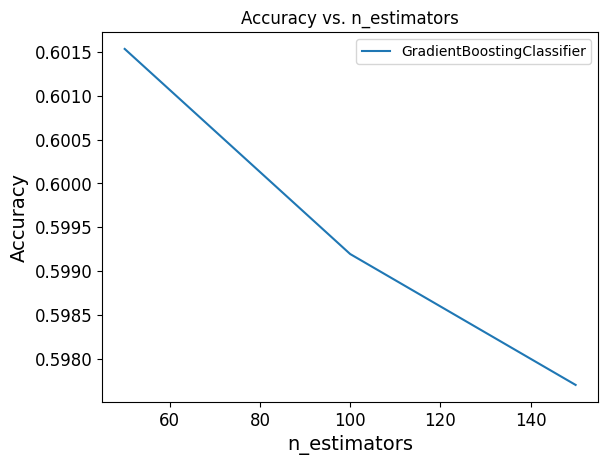

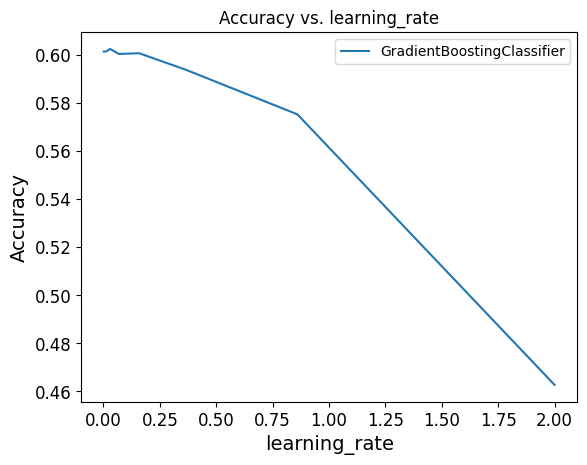

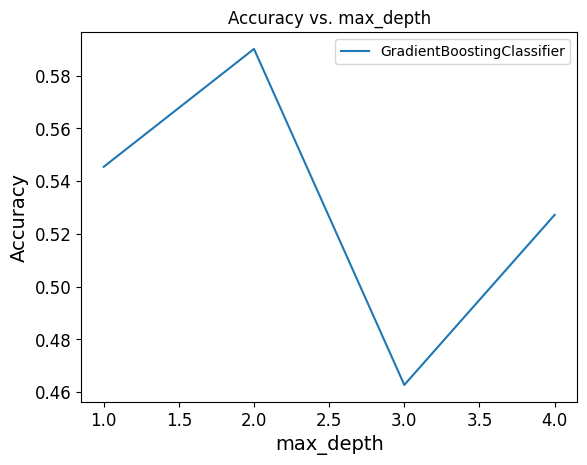

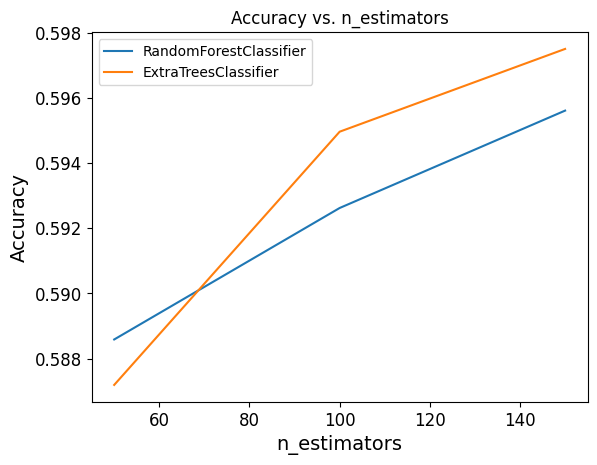

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

control = AlwaysOneClassifier()
estimators = [RandomForestClassifier(random_state=42), 
              ExtraTreesClassifier(random_state=42)]

gradient = GradientBoostingClassifier(random_state=42)

n_estimators_range = range(50, 200, 50)
learning_rate_range = np.logspace(-3, 0.30103, 10, base=10)
max_depth_range = range(1, 5)

for param_name, param_range in [("n_estimators", n_estimators_range), 
                                 ("learning_rate", learning_rate_range), 
                                 ("max_depth", max_depth_range)]:
    scores = {type(gradient).__name__: []}
    for param_value in param_range:
          gradient.set_params(**{param_name: param_value})
          print("Training the", gradient)
          gradient.fit(X_train, y_train)
          score = gradient.score(X_test, y_test)
          scores[type(gradient).__name__].append(score)
        
    plt.figure()
    plt.title("Accuracy vs. " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.plot(param_range, scores[type(gradient).__name__], label=type(gradient).__name__)
    plt.legend()

for param_name, param_range in [("n_estimators", n_estimators_range)]:
    scores = {type(estimator).__name__: [] for estimator in estimators}
    for param_value in param_range:
      for estimator in estimators:
          estimator.set_params(**{param_name: param_value})
          print("Training the", estimator)
          estimator.fit(X_train, y_train)
          score = estimator.score(X_test, y_test)
          scores[type(estimator).__name__].append(score)
        
    plt.figure()
    plt.title("Accuracy vs. " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    for estimator in estimators:
        plt.plot(param_range, scores[type(estimator).__name__], label=type(estimator).__name__)
    plt.legend()

plt.show()


These graph outputs are interesting, especially the fact that more trees impacts accuracy negativebly with the gradient boosting.
Possibly this is due to overfitting. Generally the accuracy does not change very much at all in relation to the n_estimators.
The best max_depth seems to be about 2.

Suspiciously, the best accuracy we are seeing seems to be about 60%, which is the ratio of non-ink pixels we trained on. 
It seems like our classifier might just be predicting only non-ink.

In [ ]:
# Parameters to optimize

n_estimators = 300
n_estimators_grad = 60
learning_rate = 0.25
max_depth = 2

In [ ]:
batch_voting_clf = BatchVotingClassifier([
    RandomForestClassifier(n_estimators=n_estimators, random_state=42),
    ExtraTreesClassifier(n_estimators=n_estimators, random_state=42),
    GradientBoostingClassifier(n_estimators=n_estimators_grad, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    ])

batch_voting_clf.fit(VesuviusTrainingSequence(images=images, input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=cached_rows, batch_size=batch_size, mask_suffix='train', transforms=None, seed=42))

print(batch_voting_clf.score(X_test, y_test))
# print(batch_voting_clf.score(VesuviusTrainingSequence(images=images, input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=cached_rows, batch_size=batch_size, mask_suffix='test', transforms=None, seed=42)))

print([estimator.score(X_test, y_test) for estimator in batch_voting_clf.estimators_])

Scoring: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


11831.893410370076
[0.5954076804303432, 0.5838521691487772, 0.5978482841061912]


In [ ]:
voting_clf = VotingClassifier([
    ("random_forest_clf", RandomForestClassifier(n_estimators=n_estimators, random_state=42)),
    ("extra_trees_clf", ExtraTreesClassifier(n_estimators=n_estimators, random_state=42)),
    ("grad_clf", GradientBoostingClassifier(n_estimators=n_estimators_grad, learning_rate=learning_rate, max_depth=max_depth, random_state=42)),
#    ("svm_clf", LinearSVC(max_iter=100, tol=20, random_state=42)),
#    ("mlp_clf", MLPClassifier(random_state=42)),
])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_estimators=300,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_estimators=300,
                                                   random_state=42)),
                             ('grad_clf',
                              GradientBoostingClassifier(learning_rate=0.25,
                                                         max_depth=2,
                                                         n_estimators=60,
                                                         random_state=42))])

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.5975992429147781, 0.5991931065398217, 0.5996911889226478]

AlwaysOne returns 0.39861533097574336
This is our baseline value. All the other classifiers predict suspiciously close to 1- 0.39861533097574336

In [ ]:
voting_clf.score(X_test, y_test)

0.5996413806843652

The Voting Classifier also predicts suspiciously about 0.6

In [ ]:
voting_clf.voting = "soft"
voting_clf.score(X_test, y_test)

0.6022812173133436

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.5996413806843652

Hard (majority rule) and soft (argmax of the sums of the probabilites) voting return roughly equal values

In [ ]:
X_test_predictions = np.empty((len(X_test), len(voting_clf.estimators_)), dtype=np.float32)

# a = [[1, 2, 3],
#      [4, 5, 6],
#      [7, 8, 9]]
# a[0] = [1, 2, 3]
# a[:, 0] = [1, 4, 7]
# a[1:, 1:] = [[5, 6], [8, 9]]
# a[:2, 2] = [3, 6]
# first is rows, second is colomns

for index, estimator in enumerate(voting_clf.estimators_):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=n_estimators, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_test_predictions, y_test)

RandomForestClassifier(n_estimators=300, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.601982367883648

Very little difference in accuracy here. Slightly better though

In [ ]:
X_test_predictions = np.empty((len(X_test), len(voting_clf.estimators_)), dtype=np.float32)

for index, estimator in enumerate(voting_clf.estimators_):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.601982367883648

Predicting image 1: 100%|██████████| 3558/3558 [1:47:48<00:00,  1.82s/it]


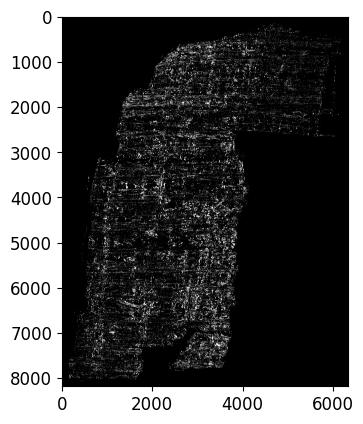

In [ ]:
show_prediction('1', voting_clf, prediction_cached_rows=None, prediction_batch_size=8192)

Predicting image 1: 100%|██████████| 3558/3558 [1:25:37<00:00,  1.44s/it]


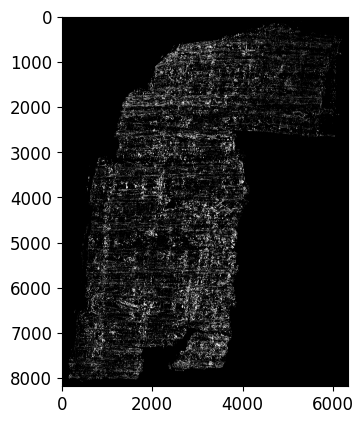

In [ ]:
show_prediction('1', batch_voting_clf, prediction_cached_rows=None, prediction_batch_size=8192)

Prediction patterns seeem similar but not identical

It is ultimately the case that Random Forest has proven ineffective. As mentioned in our presentation, it is technically possible that the method of data processing is ineffective. I expect that random forests are, however, not the correct algorithm for this task. It would be interesting to see the outcome of the 'grayscale sum' method we spoke about in class. I (George) will likely experiment with this after I finals weeks cools off and I have more time. It is an idea that I have not seen attempted based on my priliminary understanding of the competition example submissions. Wether this is beacuse it does not work, or it is a new and awesome idea reamains to be seen